### Objective
- Create models that make more of the text you're training on
- Character level language models
- Create a bigram
- Create a bag of words
- Create a MLP
- Create a RNN
- Create a GRU
- Create a Transformer

In [2]:
names = open("./data/names/names.txt").read().splitlines()
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
max(len(name) for name in names), min(len(name) for name in names)

(15, 2)

What is a character level bigram?
* A bigram is a sequence of two characters
* So a bigram model is one that predicts the next character based on the previous one
* It samples the next character from the probability distribution of all characters given the previous character

I need to build the probability distribution of all characters given each character in the vocabulary

In [4]:
vocab = sorted(list(set("".join(name for name in names))))
vocab = vocab + ["."]  ## "." means end of text or start of a new text"
vocab


['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '.']

In [5]:
distribution = [[0 for _ in range(len(vocab))] for _ in range(len(vocab))]

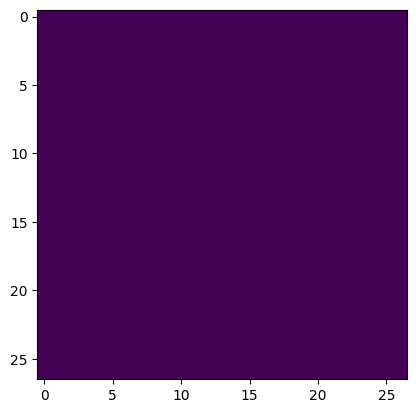

In [6]:
from matplotlib import pyplot as plt
plt.imshow(distribution)
plt.show()


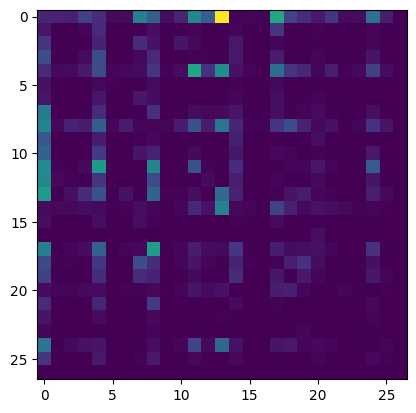

In [7]:
for name in names:
    for char1, char2 in zip(name, name[1:]):
        distribution[vocab.index(char1)][vocab.index(char2)] += 1
plt.imshow(distribution)
plt.show()


In [8]:
vocab0 = vocab[0] # a 
vocab1 = vocab[1] # b

vocab0, vocab1, distribution[vocab.index(vocab0)][vocab.index(vocab1)]  # number of times b follows a

('a', 'b', 541)

In [9]:
# We need to normalize the scores to get probabilities
# By dividing each row by the sum of the row
for distrib in distribution:
    distrib = distrib / sum(distrib)

plt.imshow(distribution)
plt.show()


TypeError: unsupported operand type(s) for /: 'list' and 'int'

Lists don't support broadcasting, let's use tensors

In [10]:
import torch
distributions = torch.tensor(distribution)
distributions.shape

torch.Size([27, 27])

Let's create a lookup table for characters to indices and vice versa, to easy inspection

In [11]:
char_to_idx = { ch: i for i, ch in enumerate(vocab) }
idx_to_char = { i: ch for i, ch in enumerate(vocab) }

next(iter(char_to_idx.items())), next(iter(idx_to_char.items()))


(('a', 0), (0, 'a'))

In [12]:
distributions[char_to_idx["a"]]  # number of times each character follows a

tensor([ 556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568, 2528,
        1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,  182,
        2050,  435,    0])

In [13]:
# normalizing the distribution to get probabilities
(distributions / distributions.sum(dim=1, keepdim=True)).sum(dim=1, keepdim=True)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [   nan]])

We forgot to add the special character representing start and end of texts when we built the bigrams, that's why the last row is nan. Let's rewrite it and now already using tensors

In [14]:
char_to_idx = { ch: i+1 for i, ch in enumerate(vocab) }
char_to_idx["."] = 0
idx_to_char = { i: ch for ch, i in char_to_idx.items() }

next(iter(char_to_idx.items())), next(iter(idx_to_char.items()))

(('a', 1), (1, 'a'))

In [15]:
scores = torch.zeros((27, 27))
for name in names:
    name = "." + name + "."
    for char1, char2 in zip(name, name[1:]):
        idx_1 = char_to_idx[char1]
        idx_2 = char_to_idx[char2]
        scores[idx_1, idx_2] += 1
distributions = scores / scores.sum(dim=1, keepdim=True)


(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

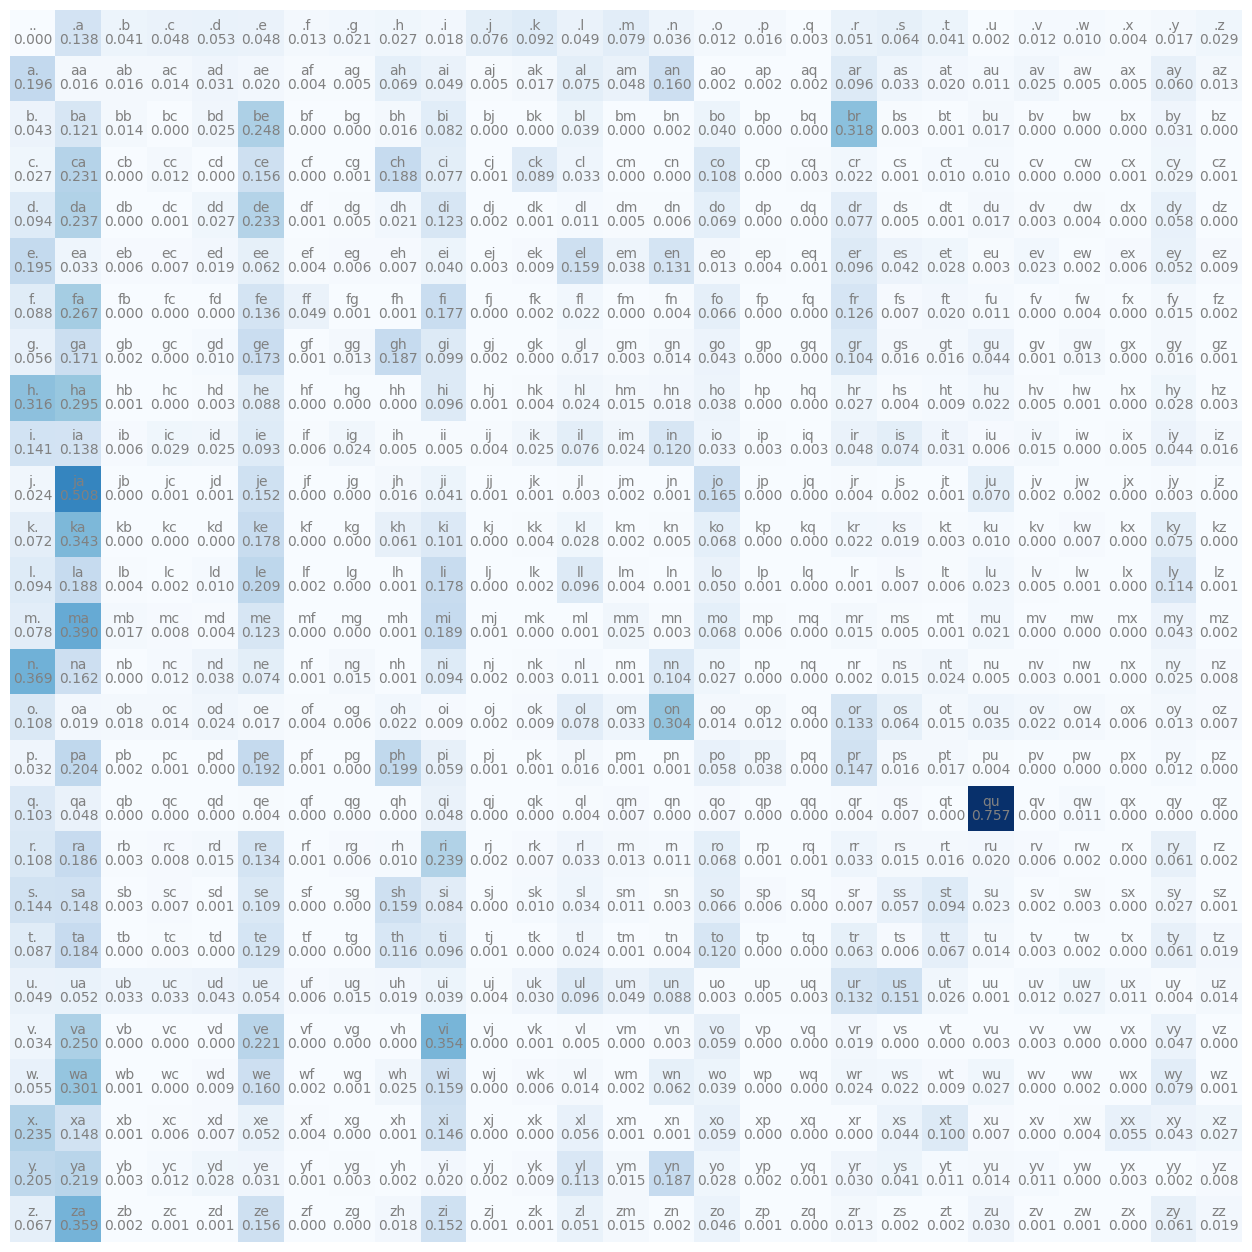

In [16]:
plt.figure(figsize=(16, 16))
plt.imshow(distributions, cmap="Blues")
for i in range(27):
    for j in range(27):
        bigram = idx_to_char[i] + idx_to_char[j]
        plt.text(j, i, bigram, ha="center", va="bottom", color="gray")
        plt.text(j, i, f"{distributions[i, j].item():.3f}", ha="center", va="top", color="gray")
plt.axis("off")

Now that we have the conditional probability distribution given each character for all characters, we can iteratively sample from it to generate new names!

In [17]:
start_char = "."
idx = char_to_idx[start_char]
distributions[idx, :]

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

How can we sample from it? We can use the torch.multinomial function, that given a probability distribution, it will sample idxs the number times you specify from the distribution

In [18]:
sample_idxs = torch.multinomial(distributions[idx, :], num_samples=1, replacement=True)
sample_idxs.item(), idx_to_char[sample_idxs.item()]

(2, 'b')

In [19]:
from torch import Generator
generator = Generator().manual_seed(2147483647)  # to make runs deterministic, useful to reproduce and find bugs

In [20]:
for _ in range(10):
    name = ""
    idx = 0
    while True:
        d = distributions[idx]
        idx = torch.multinomial(d, num_samples=1, replacement=True, generator=generator).item()
        name += idx_to_char[idx]
        if idx == 0:
            break
    print(name[1:-1])

exze
omasurailezitynn
onimittain
layn
a
a
taiyaubrtthrigotai
oliellavo
e
eda


Considering we have 27 characters, we can infer that the probability of randomly sampling a character is 1/27.

In [21]:
1 / 27.

0.037037037037037035

So if we print the probabilities our model assigned to each bigram, we'll know that we've learned something whenever the probability is higher than 1/27 ± 3.8%.

In [22]:
for name in names[:3]:
    name = "." + name + "."
    for char1, char2 in zip(name, name[1:]):
        idx_1 = char_to_idx[char1]
        idx_2 = char_to_idx[char2]
        prob = distributions[idx_1, idx_2]
        print(f"{char1}{char2}: {prob.item():.4f}")

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3899
a.: 0.1960
.o: 0.0123
ol: 0.0780
li: 0.1777
iv: 0.0152
vi: 0.3541
ia: 0.1381
a.: 0.1960
.a: 0.1377
av: 0.0246
va: 0.2495
a.: 0.1960


So, given the probabilities our model assigns to each bigram, how can we measure how good our model is?

We should measure the likelihood L(theta | X), where theta are the parameters of our model and x is the data observed, and it's read as "the probability of the observed data given that theta are the true parameters".

The likelihood is the product of the probabilities of the observed data given the parameters. Because we assume:

* Each sample is independent of the others
* Each sample is identically distributed (it follows the same underlying probability distribution)

So considering X = {x_1, x_2, ..., x_n} and theta are the parameters of our model, we have:

L(theta | X) = P(x_1, x_2, ..., x_n | theta) = P(x_1 | theta) * P(x_2 | theta) * ... * P(x_n | theta)

We can estimate this by sampling a lot of data from our model and then calculating the likelihood of the data. So the higher the likelihood, the better our model is. Therefore we aim to maximize the likelihood.

However is easy to see that product of probabilities will yield a small number, that will be prone to numerical instability.

To avoid this, we can take the logarithm of the likelihood, which is a monotonically increasing function. So the maximum of the likelihood will also be the maximum of the logarithm of the likelihood.

log(L(theta | X)) = log(P(x_1 | theta)) + log(P(x_2 | theta)) + ... + log(P(x_n | theta))

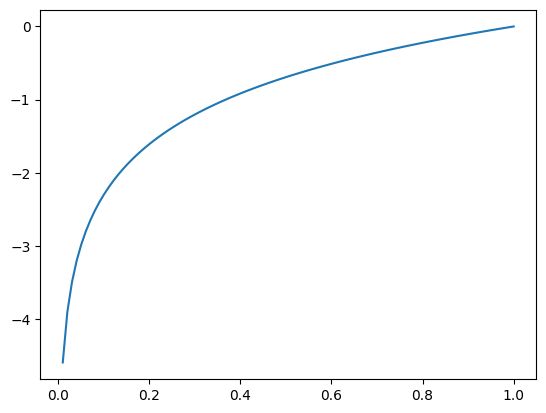

In [23]:
# We can see that the log is scaling values from 0 to 1 (the probabilities) to -inf to 0
# As the probabilities get closer to 0, the log of the probabilities get closer to -inf
# As the probabilities get closer to 1, the log of the probabilities get closer to 0
# This is useful because it scales the values to a range that doesn't suffer from numerical instability
x = torch.linspace(0, 1, 100)
y = torch.log(x)
plt.plot(x, y)
plt.show()

In [24]:
log_likelihood = 0
n = 0
for name in names[:3]:
    name = "." + name + "."
    for char1, char2 in zip(name, name[1:]):
        idx_1 = char_to_idx[char1]
        idx_2 = char_to_idx[char2]
        prob = distributions[idx_1, idx_2]
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        print(f"{char1}{char2}: {prob.item():.4f} {log_prob.item():.4f}")
        n += 1

nll = -log_likelihood
avg_nll = nll / n
print(f"{nll=}, {avg_nll=}")

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299
.a: 0.1377 -1.9829
av: 0.0246 -3.7045
va: 0.2495 -1.3882
a.: 0.1960 -1.6299
nll=tensor(38.7856), avg_nll=tensor(2.4241)


In [25]:
log_likelihood = 0
n = 0
name = "." + "guilherme" + "."
for char1, char2 in zip(name, name[1:]):
    idx_1 = char_to_idx[char1]
    idx_2 = char_to_idx[char2]
    prob = distributions[idx_1, idx_2]
    log_prob = torch.log(prob)
    log_likelihood += log_prob
    print(f"{char1}{char2}: {prob.item():.4f} {log_prob.item():.4f}")
    n += 1

nll = -log_likelihood
avg_nll = nll / n
print(f"{nll=}, {avg_nll=}")

.g: 0.0209 -3.8687
gu: 0.0441 -3.1211
ui: 0.0386 -3.2546
il: 0.0760 -2.5772
lh: 0.0014 -6.5994
he: 0.0885 -2.4248
er: 0.0959 -2.3447
rm: 0.0128 -4.3618
me: 0.1232 -2.0943
e.: 0.1950 -1.6346
nll=tensor(32.2812), avg_nll=tensor(3.2281)


What if there's a character that doesn't follow any other character?
We get a -inf log probability
In order to avoid this we can add a small epsilon to the probability of the character that doesn't follow any other character
Or add a number to the count of all characters, this way we'd be smoothing the distribution, and we'd be adding a small probability to the character that doesn't follow any other character

In [26]:
scores += 1
smoothed_distributions = scores / scores.sum(dim=1, keepdim=True)

In [27]:
log_likelihood = 0
smoothed_log_likelihood = 0
n = 0
name = "." + "qguilherme" + "."
for char1, char2 in zip(name, name[1:]):
    idx_1 = char_to_idx[char1]
    idx_2 = char_to_idx[char2]
    prob = distributions[idx_1, idx_2]
    smoothed_prob = smoothed_distributions[idx_1, idx_2]
    log_prob = torch.log(prob)
    smoothed_log_prob = torch.log(smoothed_prob)
    log_likelihood += log_prob
    smoothed_log_likelihood += smoothed_log_prob
    print(f"{char1}{char2}: {prob.item():.4f} {log_prob.item():.4f}")
    print(f"{char1}{char2}: {smoothed_prob.item():.4f} {smoothed_log_prob.item():.4f}")
    n += 1

nll = -log_likelihood
smoothed_nll = -smoothed_log_likelihood
avg_nll = nll / n
smoothed_avg_nll = smoothed_nll / n
print(f"{nll=}, {avg_nll=}")
print(f"{smoothed_nll=}, {smoothed_avg_nll=}")

.q: 0.0029 -5.8527
.q: 0.0029 -5.8428
qg: 0.0000 -inf
qg: 0.0033 -5.7004
gu: 0.0441 -3.1211
gu: 0.0440 -3.1233
ui: 0.0386 -3.2546
ui: 0.0386 -3.2549
il: 0.0760 -2.5772
il: 0.0759 -2.5780
lh: 0.0014 -6.5994
lh: 0.0014 -6.5500
he: 0.0885 -2.4248
he: 0.0883 -2.4268
er: 0.0959 -2.3447
er: 0.0958 -2.3455
rm: 0.0128 -4.3618
rm: 0.0128 -4.3577
me: 0.1232 -2.0943
me: 0.1228 -2.0971
e.: 0.1950 -1.6346
e.: 0.1948 -1.6357
nll=tensor(inf), avg_nll=tensor(inf)
smoothed_nll=tensor(39.9124), smoothed_avg_nll=tensor(3.6284)


In summary:
* GOAL: maximize the likelihood of the observed data w.r.t the parameters of the model
* Equivalent to maximize the log likelihood (because log is monotonic)
* Equivalent to minimize the negative log likelihood
* Equivalent to minimize the average negative log likelihood of the observed data

In [28]:
# let's cast the bigram approach to a neural network one
# we'll use a MLP to predict the next character given the previous one
# let's create the dataset
xs, ys = [], []
for name in names:
    name = "." + name + "."
    for char1, char2 in zip(name, name[1:]):
        idx_1 = char_to_idx[char1]
        idx_2 = char_to_idx[char2]
        xs.append(idx_1)
        ys.append(idx_2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
xs.shape, ys.shape

(torch.Size([228146]), torch.Size([228146]))

How are we going to feed this data to a neural network?
* We're going to use a simple neural network
* The simplest neural network is:
    * A linear layer
* How could we feed single integers to a linear layer? That is not possible, since it expects a vector as input.
* We'll do it by embedding the integers in a vector space, by creating one-hot vectors.
* For example, if we have a vocabulary of 27 characters, we'll create a one-hot vector of size 27 for each character.
* The one-hot vector will have a 1 at the index of the character, and 0s at all other indices.





In [29]:
from torch.nn import functional as F
xenc = F.one_hot(xs[:5], num_classes=27).float()
xenc.shape

torch.Size([5, 27])

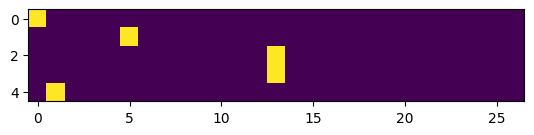

In [30]:
plt.imshow(xenc)  # .emma


In [31]:
from einops import einsum

* Now let's create a weight matrix W that will linear map the one-hot encoded characters to a new vector space, the neurons vector space.
* Considering we define the simplest neural network as a single linear layer, we want to generate a vector of size 27 for each character.
* The same way we had the scores or counts of bigrams, with the neural network we'll output the scores of the next character for each character in the vocabulary.

In [32]:
W = torch.randn((27, 27))

torch.Size([5, 27])

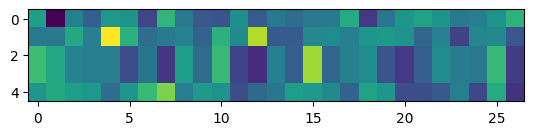

In [33]:
n = einsum(xenc, W, "batch vocab, vocab activations -> batch activations")
plt.imshow(n)  # here we can see the neurons activation for each character in emma
n.shape

In [34]:
# to illustrate the linear transformation, let's take the third character in emma and see the 13th neuron activation
# which we could also get by applying the dot product between the one-hot encoded character and the 13th column of the weight matrix
# (1, 27) @ (27, 1) = (1,)
n[3, 13], (xenc[3] * W[:, 13]).sum()

(tensor(0.0653), tensor(0.0653))

In [35]:
# As in the bigram case, we want to look at the probability distribution of the all the characters given the previous one
# In the bigram case we had the scores/counts of bigrams and averaged them to get the probabilities
# We did this because probability distributions are formed by:
# positive numbers, between 0 and 1, and the sum of the probabilities is 1
# However we can see that the scores are negative, so how can we get the probabilities?
n[3] 

tensor([ 1.5759,  1.0395,  0.1476,  0.0898,  0.0641, -1.0547, -0.1670, -1.4702,
         0.8309, -0.3578,  1.5163, -1.2601, -1.6696,  0.0653, -0.6545,  2.5591,
        -0.5216,  0.1330,  0.3703, -0.8965, -1.4581, -0.6846,  0.3879,  0.0474,
        -0.0818,  1.4678, -1.3862])

In [36]:
# So first we need to convert the activations to positive numbers
# We can do this by exponentiating the activations
n[3].exp()

tensor([ 4.8351,  2.8278,  1.1591,  1.0939,  1.0661,  0.3483,  0.8462,  0.2299,
         2.2954,  0.6992,  4.5554,  0.2836,  0.1883,  1.0675,  0.5197, 12.9236,
         0.5935,  1.1422,  1.4482,  0.4080,  0.2327,  0.5043,  1.4739,  1.0485,
         0.9215,  4.3398,  0.2500])

In [38]:
# Now that we have positive numbers, we can normalize them to get a probability distribution
prob_distr = n[3].exp() / n[3].exp().sum()
prob_distr, prob_distr.sum()


(tensor([0.1022, 0.0598, 0.0245, 0.0231, 0.0225, 0.0074, 0.0179, 0.0049, 0.0485,
         0.0148, 0.0963, 0.0060, 0.0040, 0.0226, 0.0110, 0.2732, 0.0125, 0.0241,
         0.0306, 0.0086, 0.0049, 0.0107, 0.0312, 0.0222, 0.0195, 0.0917, 0.0053]),
 tensor(1.0000))

In [39]:
# so we can interpret the activations as the log-counts of bigrams, aka logits
logits = einsum(xenc, W, "batch vocab, vocab activations -> batch activations")
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs.shape, probs.sum(dim=1)

(torch.Size([5, 27]), tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000]))

Summary:
* Each char index is embedded in the one-hot encode vector space
* So a word like .emma will produce an input vector with shape (5, 27)
* Our neural network is a single linear layer, W with shape (27, 27)
* Such that when applying the linear mapping from input to output space we'll have (batch vocab, vocab vocab -> batch vocab)
* Hence generating 27 activations per character in the batch
* We need to turn the activations into probabilities, so we exponentiate them and normalize
* 

In [40]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)  # randomly initialized 27 neurons weights; where each neuron receives 27 inputs 

In [41]:
xenc = F.one_hot(xs, num_classes=27).float()
logits = einsum(xenc, W, "batch vocab, vocab activations -> batch activations")
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs.shape, probs.sum(dim=1)

(torch.Size([228146, 27]),
 tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        grad_fn=<SumBackward1>))

We can see that all operations above are differentiable, so:
* We can define a loss function and apply backpropagation
* einsum is simply multiplications and sums, both of which are differentiable
* exp is the exponential and normalizations (sum and division) are both differentiable as well


In [42]:
# Let's see how we can use this to train our network
# Let's define a loop to generate the loss (here the negative log likelihood) for the first 5 characters of emma
nll = torch.zeros(5)
for i in range(5):
    x = xs[i].item()
    y = ys[i].item()
    print(f"bigram: {idx_to_char[x]}{idx_to_char[y]}")
    print(f"input: {idx_to_char[x]}")
    prob = probs[i, y]
    print(f"expected output: {idx_to_char[y]}")
    print(f"prob assigned by the model to the expected output: {prob.item():.4f}")
    nll[i] = -torch.log(prob)
    print(f"nll: {nll[i].item():.4f}")
print(f"average nll: {nll.mean().item():.4f}")

bigram: .e
input: .
expected output: e
prob assigned by the model to the expected output: 0.0123
nll: 4.3993
bigram: em
input: e
expected output: m
prob assigned by the model to the expected output: 0.0181
nll: 4.0146
bigram: mm
input: m
expected output: m
prob assigned by the model to the expected output: 0.0267
nll: 3.6234
bigram: ma
input: m
expected output: a
prob assigned by the model to the expected output: 0.0737
nll: 2.6081
bigram: a.
input: a
expected output: .
prob assigned by the model to the expected output: 0.0150
nll: 4.2012
average nll: 3.7693


Let's optimize the weights to minimize the loss

In [43]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)  # randomly initialized 27 neurons weights; where each neuron receives 27 inputs 

In [44]:
xenc = F.one_hot(xs, num_classes=27).float()
logits = einsum(xenc, W, "batch vocab, vocab activations -> batch activations")
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs.shape, probs.sum(dim=1)

(torch.Size([228146, 27]),
 tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        grad_fn=<SumBackward1>))

In [45]:
# to calculate the loss, we need to access the output probs
probs_out = probs[torch.arange(5), ys[:5]]
probs_out.shape, probs_out

(torch.Size([5]),
 tensor([0.0123, 0.0181, 0.0267, 0.0737, 0.0150], grad_fn=<IndexBackward0>))

In [46]:
loss = -probs_out.log().mean()
W.grad = None
loss.backward()
loss

tensor(3.7693, grad_fn=<NegBackward0>)

In [47]:
# let's see the gradient of the loss with respect to the weights, of weight 0, 1
W.grad[0, 1], W.shape

(tensor(0.0020), torch.Size([27, 27]))

In [48]:
# let's update the weights
W.data -= 0.1 * W.grad

Let's do a full example now

In [49]:
xs, ys = [], []
for name in names:
    name = "." + name + "."
    for char1, char2 in zip(name, name[1:]):
        idx_1 = char_to_idx[char1]
        idx_2 = char_to_idx[char2]
        xs.append(idx_1)
        ys.append(idx_2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num_elements = xs.nelement()

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) 

xs.shape, ys.shape, num_elements

(torch.Size([228146]), torch.Size([228146]), 228146)

In [50]:
for epoch in range(100):
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = einsum(xenc, W, "batch vocab, vocab activations -> batch activations")
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(num_elements), ys].log().mean()
    W.grad = None
    loss.backward()
    W.data -= 10 * W.grad
    print(f"epoch {epoch}, loss: {loss.item():.4f}")


epoch 0, loss: 3.7590
epoch 1, loss: 3.6703
epoch 2, loss: 3.5912
epoch 3, loss: 3.5200
epoch 4, loss: 3.4558
epoch 5, loss: 3.3977
epoch 6, loss: 3.3452
epoch 7, loss: 3.2976
epoch 8, loss: 3.2545
epoch 9, loss: 3.2154
epoch 10, loss: 3.1797
epoch 11, loss: 3.1472
epoch 12, loss: 3.1173
epoch 13, loss: 3.0899
epoch 14, loss: 3.0644
epoch 15, loss: 3.0409
epoch 16, loss: 3.0190
epoch 17, loss: 2.9985
epoch 18, loss: 2.9794
epoch 19, loss: 2.9615
epoch 20, loss: 2.9448
epoch 21, loss: 2.9290
epoch 22, loss: 2.9142
epoch 23, loss: 2.9002
epoch 24, loss: 2.8870
epoch 25, loss: 2.8746
epoch 26, loss: 2.8628
epoch 27, loss: 2.8516
epoch 28, loss: 2.8410
epoch 29, loss: 2.8310
epoch 30, loss: 2.8214
epoch 31, loss: 2.8123
epoch 32, loss: 2.8036
epoch 33, loss: 2.7953
epoch 34, loss: 2.7874
epoch 35, loss: 2.7798
epoch 36, loss: 2.7725
epoch 37, loss: 2.7655
epoch 38, loss: 2.7588
epoch 39, loss: 2.7524
epoch 40, loss: 2.7462
epoch 41, loss: 2.7403
epoch 42, loss: 2.7345
epoch 43, loss: 2.729